In [1]:
%%javascript
require(["codemirror/keymap/sublime", "notebook/js/cell", "base/js/namespace"],
    function(sublime_keymap, cell, IPython) {
        cell.Cell.options_default.cm_config.keyMap = 'sublime';
        var cells = IPython.notebook.get_cells();
        for(var cl=0; cl< cells.length ; cl++){
            cells[cl].code_mirror.setOption('keyMap', 'sublime');
        }
    }
);

<IPython.core.display.Javascript object>

In [2]:
# change the cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import warnings
warnings.filterwarnings('ignore')
# import all relevant func and modules from a companion .py file
from supp_lib import *
# import all samples as dictionary ...
from samples import *

In [4]:
# bounds = "rad21_merged.bed"
bounds = "union_RAD21_CTCF.bed"
feature_of_interest = bounds

## Read `feature_of_interest` that we want to look at using stackups ...
### we can also generate some random locations from hg19 using `generate_random_bed` ...

In [5]:
# bf is short for bioframe here ...
df = bf.read_table(
    feature_of_interest,
    names=["chrom","start","end"],
    usecols=(0,1,2),
    index_col=None
)
df = df.sort_values(["chrom","start"])
df = df[df["chrom"].isin(autosomal_chroms)]
df = df.reset_index(drop=True)

### explore spacing and footprints of the features being explored ...

simply plot distributions of the spacings between adjacent features and their sizes `end - start`  as well ...


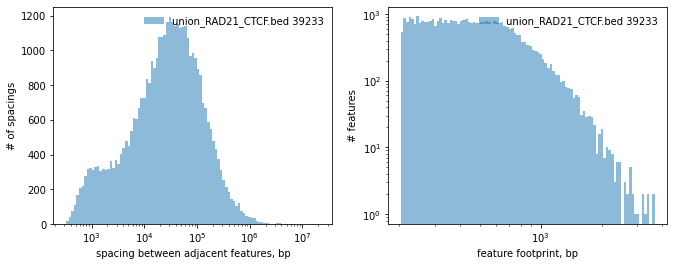

In [6]:
plot_spacing_footprint_distros({feature_of_interest:df})

### in our analyses (insulation/compartments) we wouldn't resolve features that are too close ...
#### let's see what clustering those adjacent ones could do for us
#### let's try to pick a good clustering "radius" first - should be  around ~1-10kb ...

it's actually merging that we're doing - i.e. we don't need to know cluster information - just need to collapse nearby intervals into larger ones

to see how varying clustering radius affects the results see the gist : blah ...

number of candidate features before and after merging: 39233 -> 38226


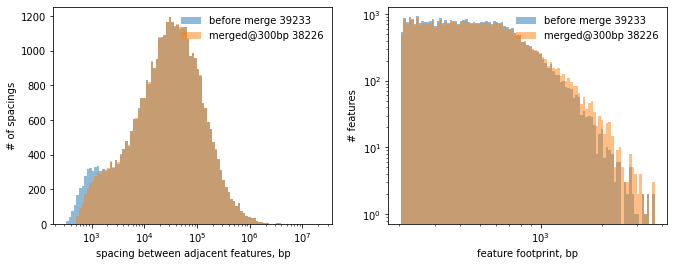

In [7]:
merge_radius = 300
df_merged = bf.merge(df, min_dist=merge_radius)
print(f"number of candidate features before and after merging: {len(df)} -> {len(df_merged)}")

plot_spacing_footprint_distros({
    "before merge":df,
    f"merged@{merge_radius}bp":df_merged,
})

### after we explored how our features (intervals) are spaced and distributed
#### we can move on to the stackups - for different samples, different types of tracks, etc

In [8]:
#let's describe our samples that we want to have in Figure 1 ...
suppfig1_samples = ["ctcf","noctcf","rad21_CTCF","rad21_noCTCF","ins_CTCF","ins_noCTCF","ev1_CTCF","ev1_noCTCF","G4a_r2"]
titles = suppfig1_samples

bw_fnames = OrderedDict()
binsizes = {}
flanks = {}
limss = {}
cmps = {}
norms = {}
for s in suppfig1_samples:
    bw_fnames[s] = samples[s]["fname"]
    binsizes[s] = samples[s]["binsize"]
    flanks[s] = samples[s]["flank"]
    limss[s] = samples[s]["crange"]
    cmps[s] = samples[s]["cmap"]
    norms[s] = None

### next is computation heavy step - stackups using bbi ...

In [9]:
# do all stackups with the parameters ...
stackups = {}
for s in bw_fnames:
    print(f"stacking up {s} ...")
    %time stackups[s] = rstacks( bw_fnames[s], df_merged, flank=flanks[s], binsize=binsizes[s] )

stacking up ctcf ...
CPU times: user 5.26 s, sys: 216 ms, total: 5.47 s
Wall time: 5.45 s
stacking up noctcf ...
CPU times: user 4.84 s, sys: 177 ms, total: 5.02 s
Wall time: 5 s
stacking up rad21_CTCF ...
CPU times: user 5.57 s, sys: 175 ms, total: 5.75 s
Wall time: 5.72 s
stacking up rad21_noCTCF ...
CPU times: user 4.25 s, sys: 184 ms, total: 4.44 s
Wall time: 4.42 s
stacking up ins_CTCF ...
CPU times: user 3.83 s, sys: 140 ms, total: 3.97 s
Wall time: 3.96 s
stacking up ins_noCTCF ...
CPU times: user 3.82 s, sys: 188 ms, total: 4 s
Wall time: 3.99 s
stacking up ev1_CTCF ...
CPU times: user 2.63 s, sys: 104 ms, total: 2.73 s
Wall time: 2.74 s
stacking up ev1_noCTCF ...
CPU times: user 2.66 s, sys: 112 ms, total: 2.77 s
Wall time: 2.76 s
stacking up G4a_r2 ...
CPU times: user 6.6 s, sys: 172 ms, total: 6.77 s
Wall time: 6.74 s


### it's amazing how much you can do with a stack up !

we can flip certain rows !

_beware_ that we are reordering index this way, and we also might loos some rows from a stackup because of NaNs

In [11]:
# we might want to do some flipping later on  - so keeping this here for records
s0 = stackups[suppfig1_samples[0]]
preflip_index = np.arange(len(s0))
print(s0.shape)

(38226, 50)


In [12]:
# let's define how we flip things - by compartment status ...
ev1_arr = stackups["ev1_CTCF"]
preflip_index = np.arange(len(ev1_arr))
mid = int(ev1_arr.shape[1]/2)
# flip track: left average EV1 - right average EV1
ev_left_minus_right = np.nanmean(ev1_arr[:,:mid],axis=1) - \
       np.nanmean(ev1_arr[:,mid:],axis=1)

# flipped index according to EV1
flip_stackup_index = np.concatenate([
    preflip_index[ev_left_minus_right>=0],
    preflip_index[ev_left_minus_right<0]
])

# flip EVERYTHING according to the compartment
flip_stackups = {}
for s in bw_fnames:
    flip_stackups[s] = np.concatenate([
        stackups[s][ev_left_minus_right>=0],
        stackups[s][ev_left_minus_right<0][:,::-1]
    ])

# print flip condition numbers ...
print( (ev_left_minus_right>=0).sum() )
print( (ev_left_minus_right<0).sum() )
print( np.isnan(ev_left_minus_right).sum() ) # NaNs

18442
18618
1166


### Normalize insulation stackups - subtract some value from each row in the stackup ...

In [13]:
# this is done INPLACE - be carefull !
normalize_insulation_stackups_INPLACE(
    flip_stackups,
    [k for k in flip_stackups.keys() if k.startswith("ins")],
    subtract = "mean_top",
    subtract_size = 7
)

### sort by CTCF - to be able to distinguish between CTCF dep and CTCF indep groups ...

In [14]:
length,width = flip_stackups['ctcf'].shape
center_bin = int(width/2)
flip_stackups['ctcf_mean'] = np.nanmean(flip_stackups['ctcf'][:,center_bin-1:center_bin+1],axis=1)

# flip_stackups['ev_std'] = np.nanstd(flip_stackups['ev1_CTCF'],axis=1)
# flip_stackups['ev_middle_diff'] = np.abs(np.diff(flip_stackups['ev1_CTCF']))[:,3]
# flip_stackups['rad21_mean'] = np.nanmean(flip_stackups['rad21_CTCF'][:,center_bin-2:center_bin+2],axis=1)
# flip_stackups['sort_metric'] = np.log(flip_stackups['ctcf_mean']) + 0.33*flip_stackups['rad21_mean']

ins_samples = [s for s in suppfig1_samples if s.startswith("ins")]
# insulation
for s in ins_samples:
    limss[s] = (-.352,-.153)
    cmps[s] = cmapYlGnBu_r

initial_index = np.arange( len(flip_stackups['ctcf_mean']) )
ks = [('ctcf_mean', "sort", 1, False)]
# ks = [('RAD21_mean',"sort",5),('RAD21_IAA_mean',"sort",1),  ]
_, jjj = recursive_data_ordering( ks, initial_index, flip_stackups, verbose=True)


sorting 37060 elements of ctcf_mean into 1 groups ...


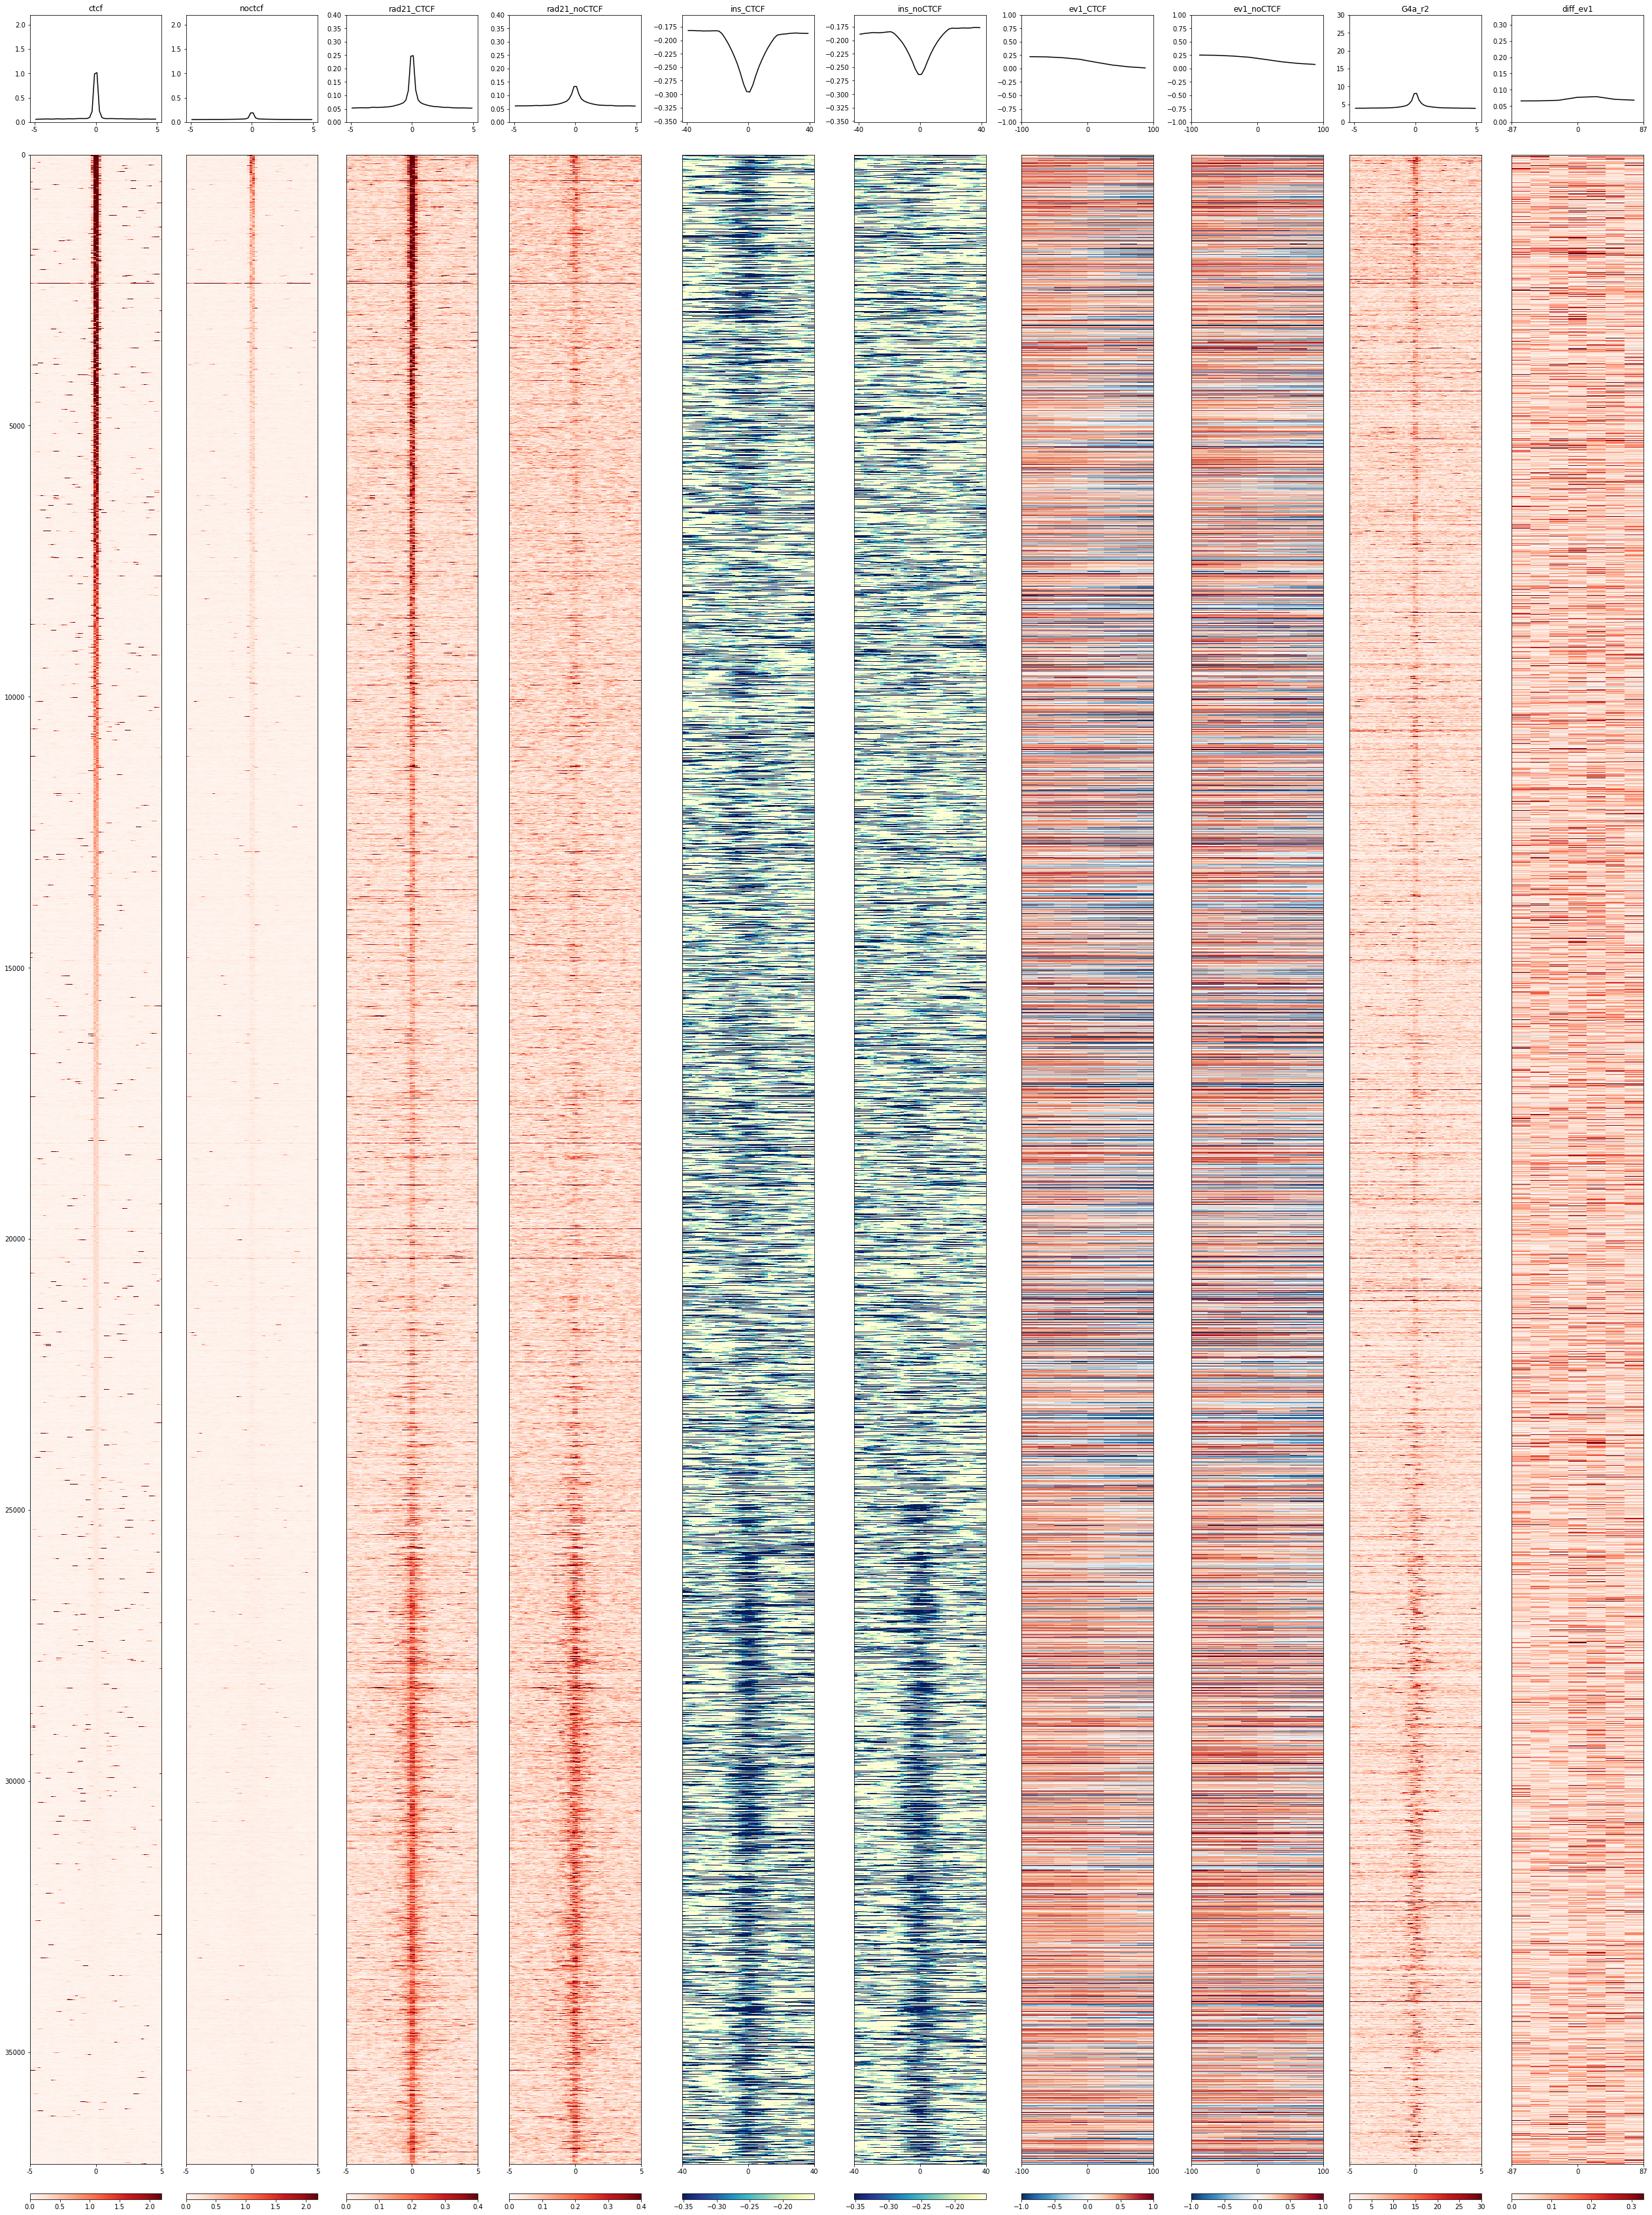

In [15]:
hmss = [ flip_stackups[_k][jjj] for _k in suppfig1_samples ]
_limss = [ limss[_k] for _k in suppfig1_samples ]
_cmps = [ cmps[_k] for _k in suppfig1_samples ]
_binsizes = [ binsizes[_k] for _k in suppfig1_samples ]
_norms = [ norms[_k] for _k in suppfig1_samples ]
_titles = [ t for t in titles]

hmss.append(np.abs(np.diff(flip_stackups['ev1_CTCF']))[jjj])
_limss.append((0.,.33))
_cmps.append(cmap3)
_binsizes.append(25000)
_norms.append(None)
_titles.append("diff_ev1")


xtra_plots = None
plot_stackups(xtra_plots, hmss,_titles, _limss, _cmps, _norms, _binsizes, fname="xxx.pdf", fillmissing=False, interpolation="nearest")

### let's plot zoom-ins into CTCF dependent and CTCF independent subsets ...

sorting 10000 elements of ev_middle_diff into 1 groups ...


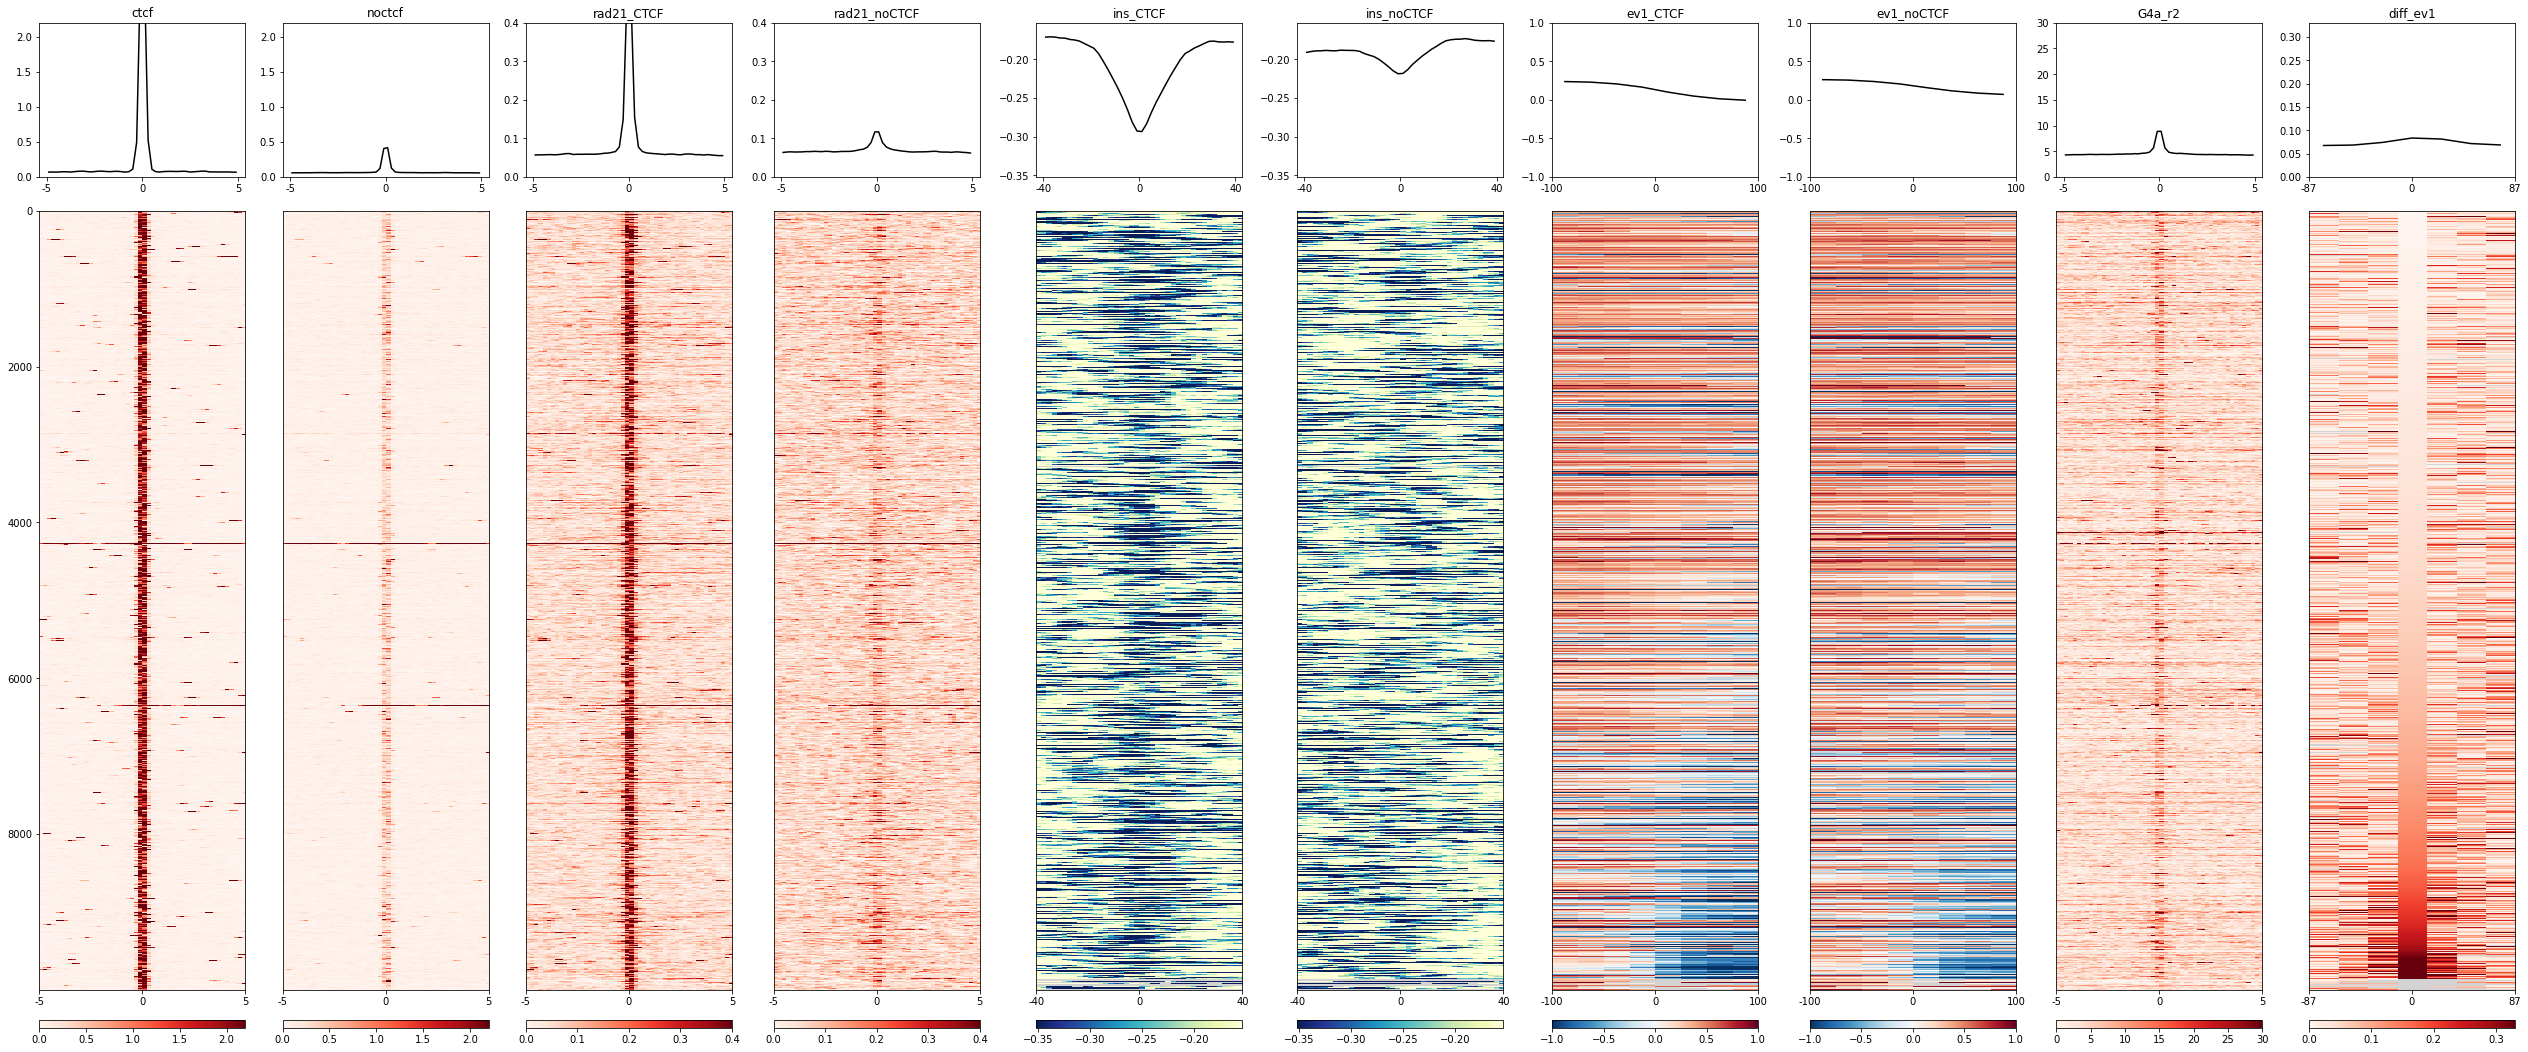

In [16]:
# let's take ~10'000 strongest CTCF harboring RAD21 peak
iii = jjj[:10_000]

_l, _w = flip_stackups['G4a_r2'].shape
_cent = int(_w/2)
tmp_dict = {}
tmp_dict['G4_mean'] = np.nanmean(flip_stackups['G4a_r2'][iii,_cent-1:_cent+1],axis=1)
tmp_dict['ev_std'] = np.nanstd(flip_stackups['ev1_CTCF'][iii],axis=1)
#
center_diff_bin = 3
tmp_dict['ev_middle_diff'] = np.abs(np.diff(flip_stackups['ev1_CTCF']))[iii,center_diff_bin]

ks = [('ev_middle_diff', "sort", 1, True)]
_, iii_reord = recursive_data_ordering( ks, np.arange(len(iii)), tmp_dict, verbose=True)

hmss = [ flip_stackups[_k][iii[iii_reord]] for _k in suppfig1_samples ]
_limss = [ limss[_k] for _k in suppfig1_samples ]
_cmps = [ cmps[_k] for _k in suppfig1_samples ]
_binsizes = [ binsizes[_k] for _k in suppfig1_samples ]
_norms = [ norms[_k] for _k in suppfig1_samples ]
_titles = [ t for t in titles]

hmss.append(np.abs(np.diff(flip_stackups['ev1_CTCF']))[iii[iii_reord]])
_limss.append((0.,.33))
_cmps.append(cmap3)
_binsizes.append(25000)
_norms.append(None)
_titles.append("diff_ev1")

plot_stackups(None, hmss,_titles,_limss,_cmps,_norms,_binsizes,fname="xxx.pdf",fillmissing=False,interpolation="nearest")


xxx_CTCFdep = copy(tmp_dict['ev_middle_diff'][iii_reord])

sorting 10000 elements of ev_middle_diff into 1 groups ...


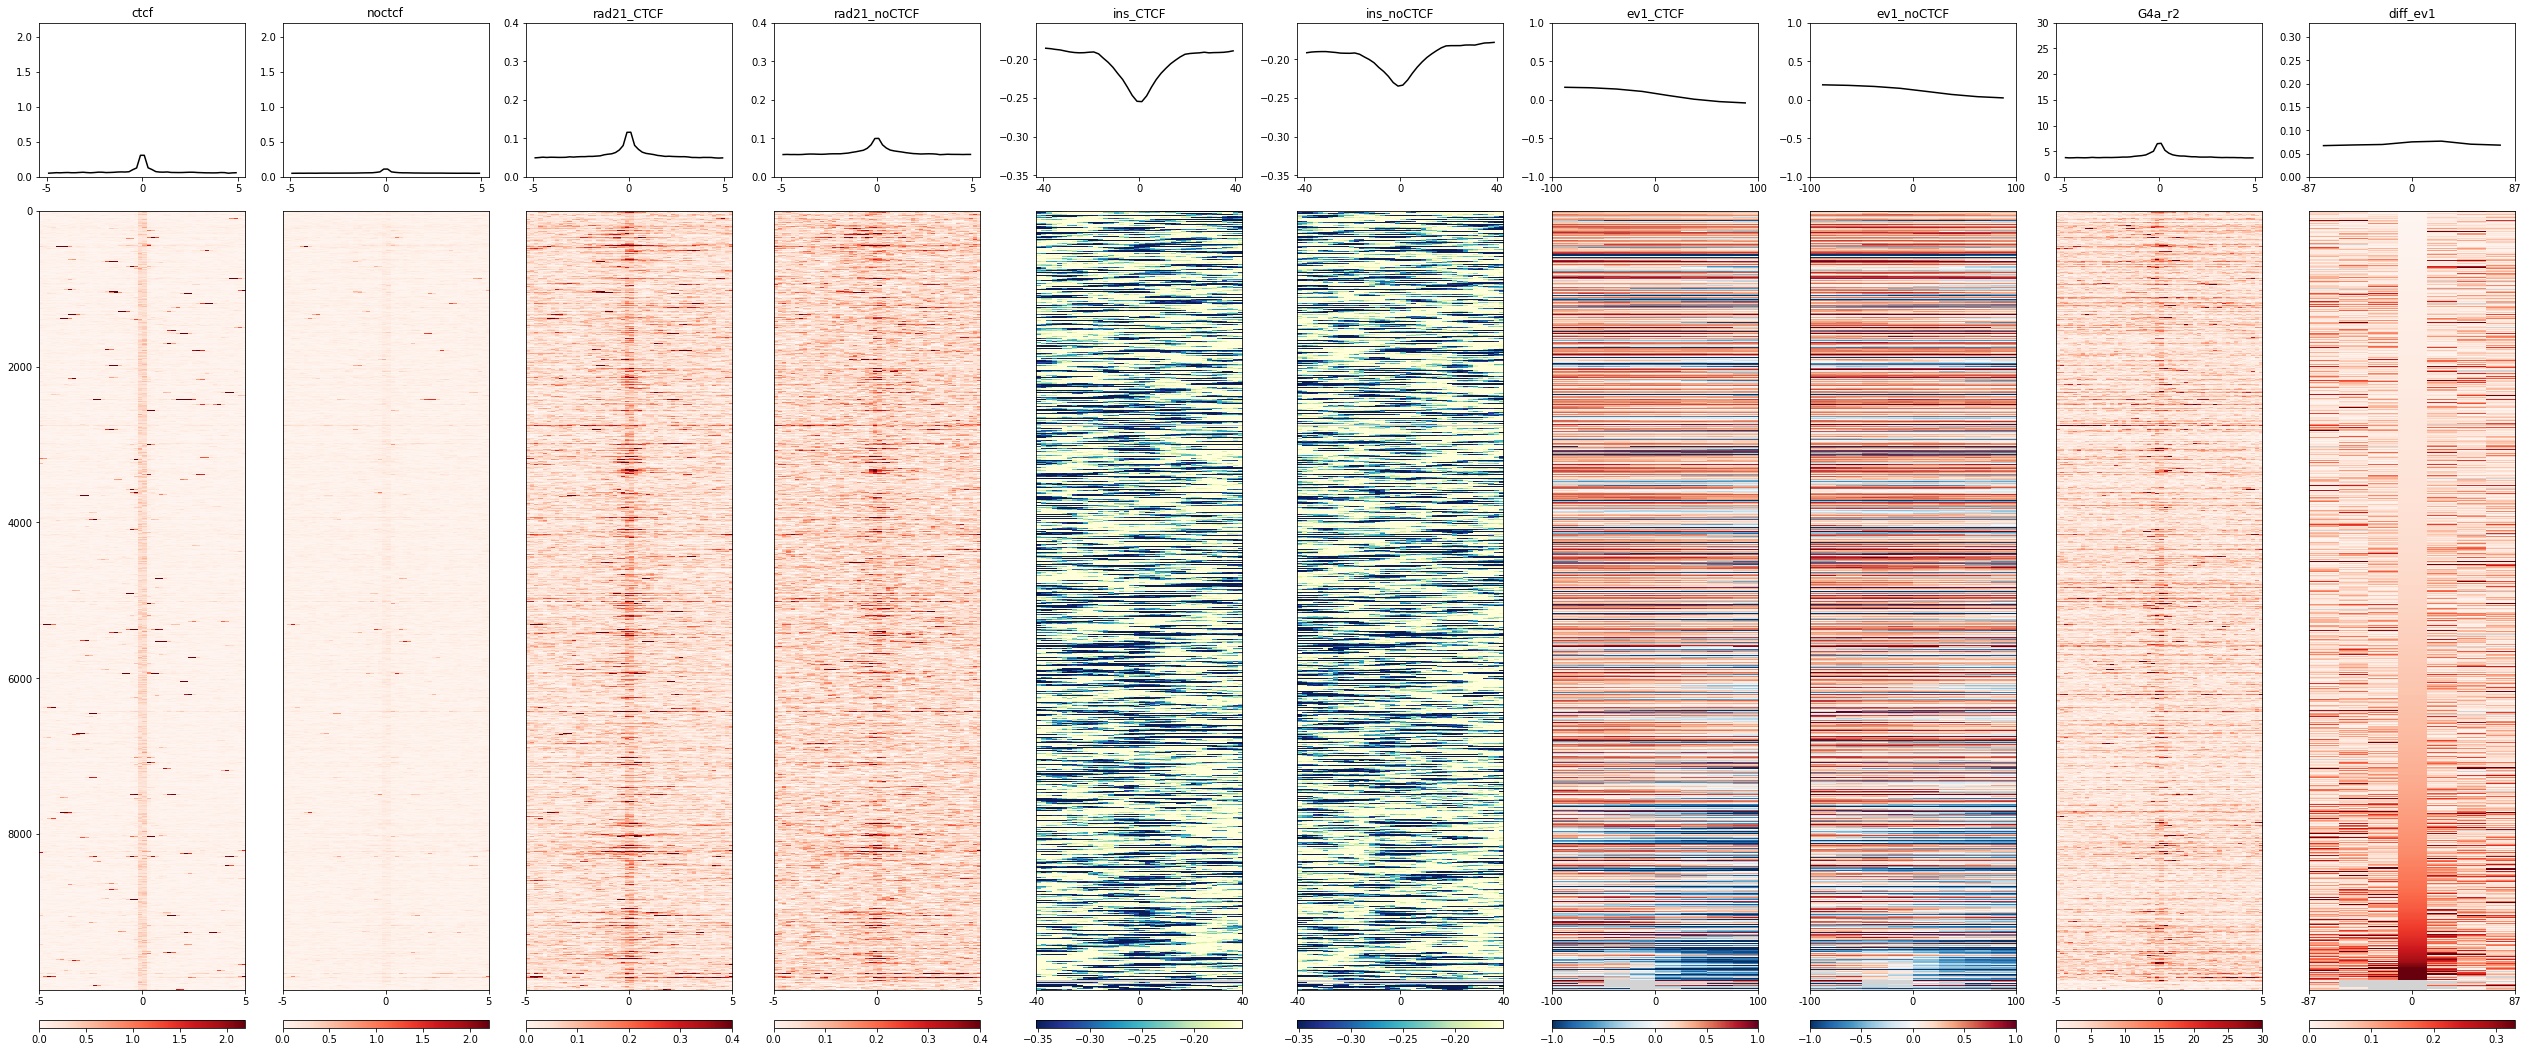

In [17]:
# let's take ~10'000 weakest CTCF harboring RAD21 peak
iii = jjj[15_000:25_000]

_l, _w = flip_stackups['G4a_r2'].shape
_cent = int(_w/2)
tmp_dict = {}
tmp_dict['G4_mean'] = np.nanmean(flip_stackups['G4a_r2'][iii,_cent-1:_cent+1],axis=1)
tmp_dict['ev_std'] = np.nanstd(flip_stackups['ev1_CTCF'][iii],axis=1)
#
center_diff_bin = 3
tmp_dict['ev_middle_diff'] = np.abs(np.diff(flip_stackups['ev1_CTCF']))[iii,center_diff_bin]

ks = [('ev_middle_diff', "sort", 1, True)]
_, iii_reord = recursive_data_ordering( ks, np.arange(len(iii)), tmp_dict, verbose=True)

hmss = [ flip_stackups[_k][iii[iii_reord]] for _k in suppfig1_samples ]
_limss = [ limss[_k] for _k in suppfig1_samples ]
_cmps = [ cmps[_k] for _k in suppfig1_samples ]
_binsizes = [ binsizes[_k] for _k in suppfig1_samples ]
_norms = [ norms[_k] for _k in suppfig1_samples ]
_titles = [ t for t in titles]

hmss.append(np.abs(np.diff(flip_stackups['ev1_CTCF']))[iii[iii_reord]])
_limss.append((0.,.33))
_cmps.append(cmap3)
_binsizes.append(25000)
_norms.append(None)
_titles.append("diff_ev1")

plot_stackups(None, hmss,_titles,_limss,_cmps,_norms,_binsizes,fname="xxx.pdf",fillmissing=False,interpolation="nearest")
xxx_CTCFmid = copy(tmp_dict['ev_middle_diff'][iii_reord])

sorting 10000 elements of ev_middle_diff into 1 groups ...


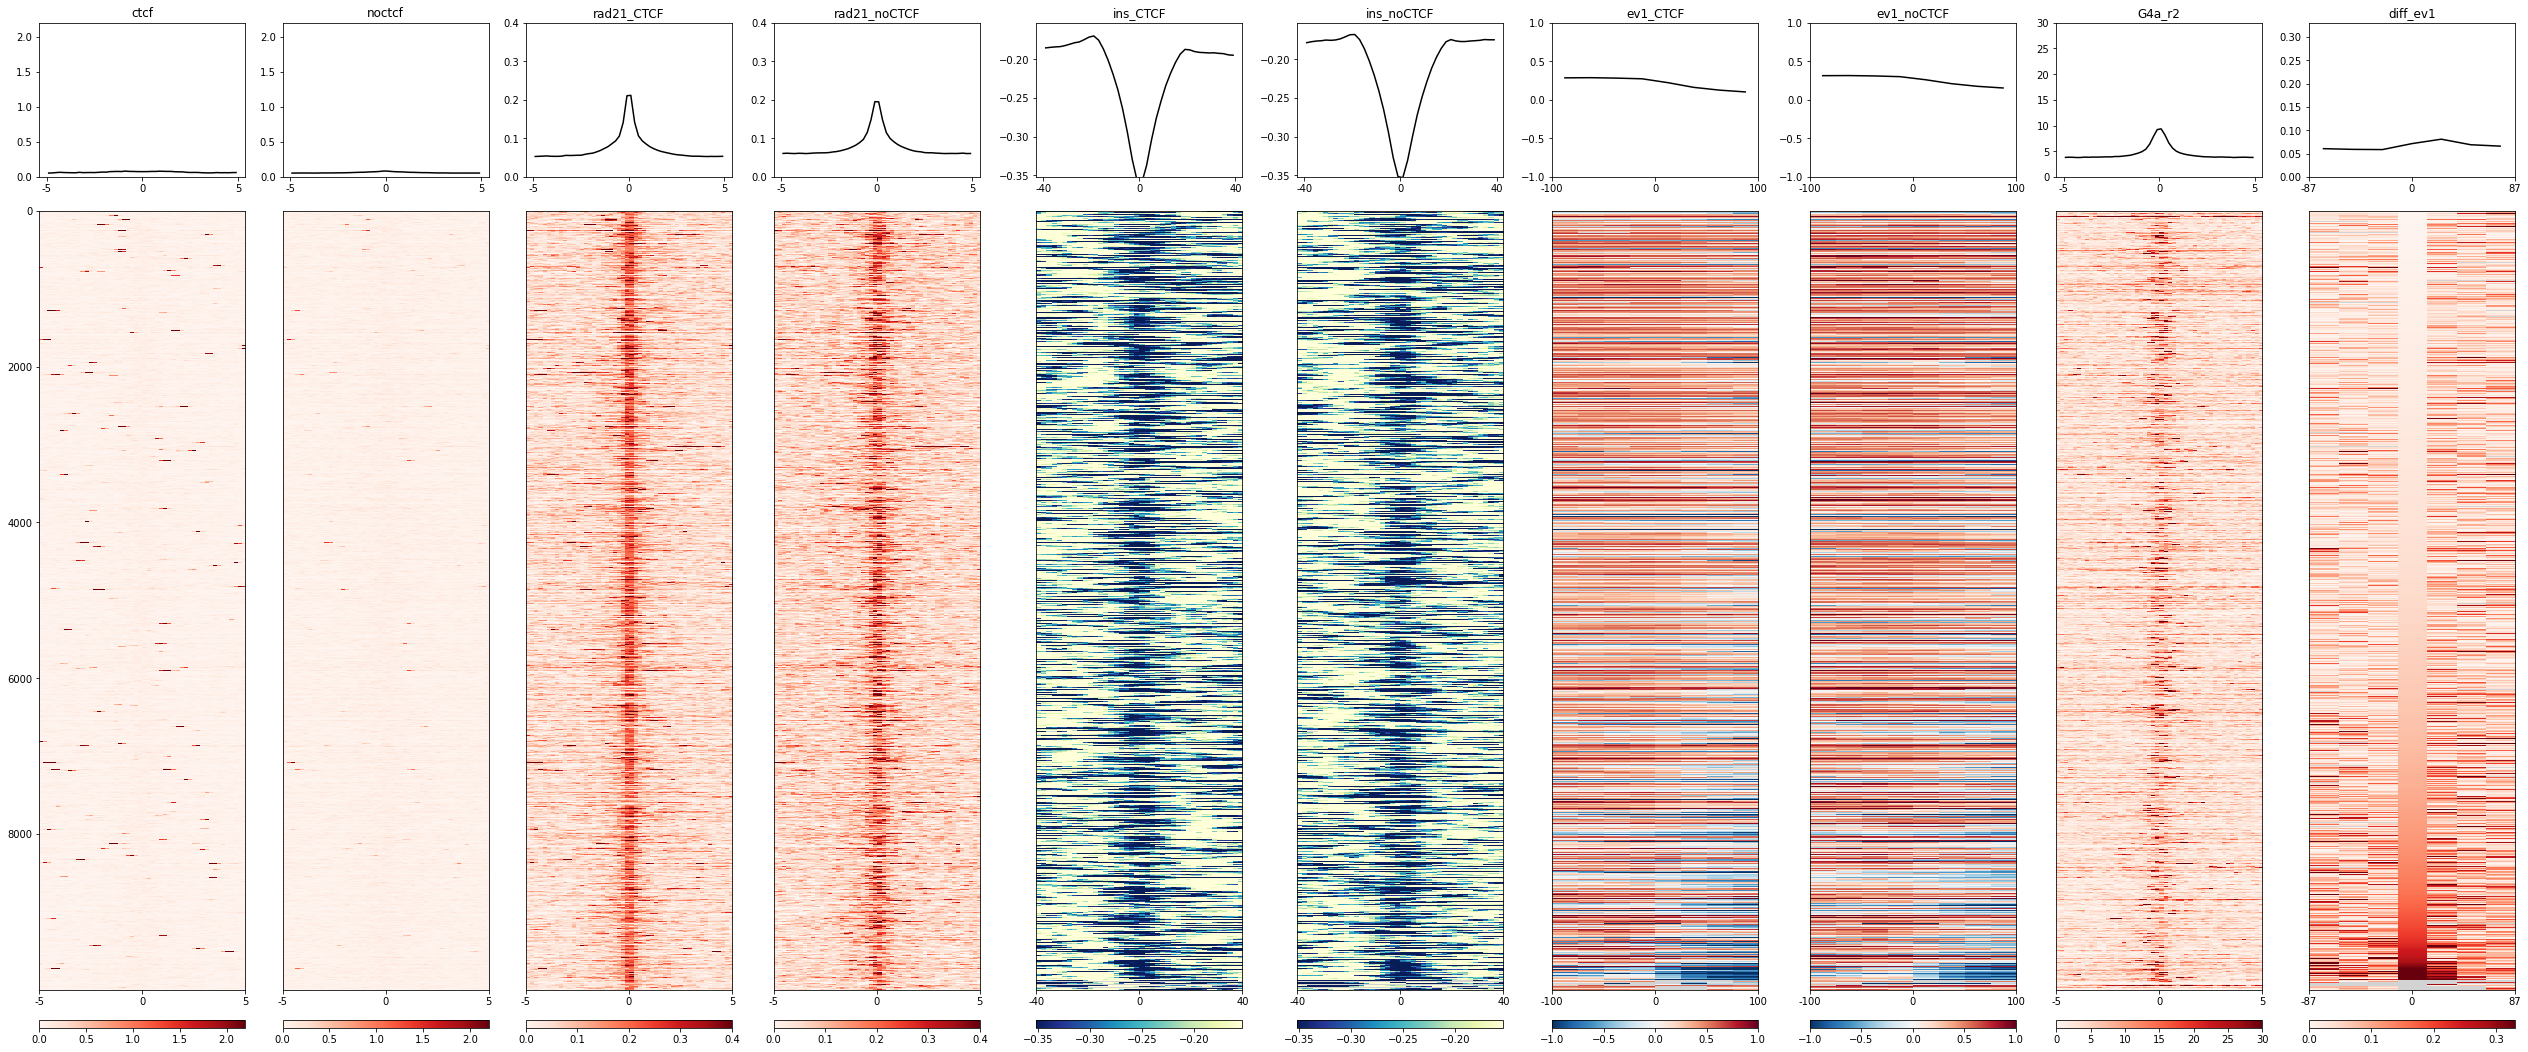

In [18]:
# let's take ~10'000 weakest CTCF harboring RAD21 peak
iii = jjj[-10_000:]

_l, _w = flip_stackups['G4a_r2'].shape
_cent = int(_w/2)
tmp_dict = {}
tmp_dict['G4_mean'] = np.nanmean(flip_stackups['G4a_r2'][iii,_cent-1:_cent+1],axis=1)
tmp_dict['ev_std'] = np.nanstd(flip_stackups['ev1_CTCF'][iii],axis=1)
#
center_diff_bin = 3
tmp_dict['ev_middle_diff'] = np.abs(np.diff(flip_stackups['ev1_CTCF']))[iii,center_diff_bin]

ks = [('ev_middle_diff', "sort", 1, True)]
_, iii_reord = recursive_data_ordering( ks, np.arange(len(iii)), tmp_dict, verbose=True)

hmss = [ flip_stackups[_k][iii[iii_reord]] for _k in suppfig1_samples ]
_limss = [ limss[_k] for _k in suppfig1_samples ]
_cmps = [ cmps[_k] for _k in suppfig1_samples ]
_binsizes = [ binsizes[_k] for _k in suppfig1_samples ]
_norms = [ norms[_k] for _k in suppfig1_samples ]
_titles = [ t for t in titles]

hmss.append(np.abs(np.diff(flip_stackups['ev1_CTCF']))[iii[iii_reord]])
_limss.append((0.,.33))
_cmps.append(cmap3)
_binsizes.append(25000)
_norms.append(None)
_titles.append("diff_ev1")

plot_stackups(None, hmss,_titles,_limss,_cmps,_norms,_binsizes,fname="xxx.pdf",fillmissing=False,interpolation="nearest")
xxx_CTCFindep = copy(tmp_dict['ev_middle_diff'][iii_reord])

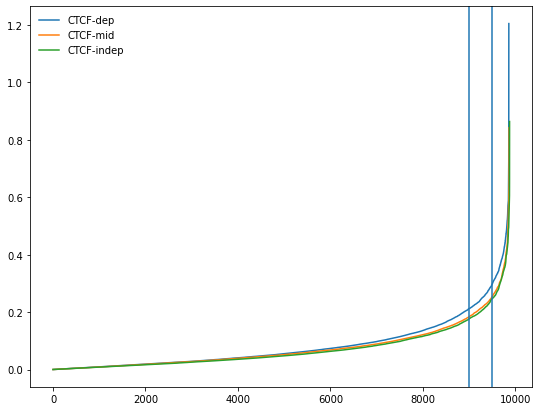

In [19]:
plt.figure(figsize=(9,7))
plt.plot(xxx_CTCFdep,label="CTCF-dep")
plt.plot(xxx_CTCFmid,label="CTCF-mid")
plt.plot(xxx_CTCFindep,label="CTCF-indep")
ax = plt.gca()
ax.axvline(len(xxx_CTCFdep)*0.9)
ax.axvline(len(xxx_CTCFdep)*0.95)
plt.legend(frameon=False)

In [20]:
# # check what we have here locally ...
# ! ls Fig1*pdf
# ! ls master*bed
# ! ssh ghpcc ls /nl/umw_job_dekker/users/sv49w/ALV2021

In [21]:
# !scp Fig1_masterlist* ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/
# !scp masterlist*.bed ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/